In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import cm # For display


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.layers import Reshape, UpSampling2D, Conv2DTranspose # for decoder
from tensorflow.keras.layers import Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [66]:
# Exportable functions

# Debug
def print_this(name, value):
    print(f"{name} = {value}")
          
x = np.array([3, 0])
print_this('x', x)

x = [3 0]


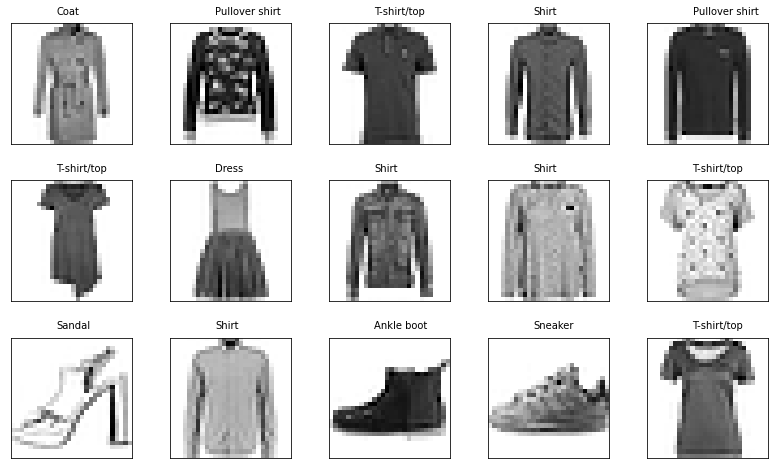

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train/255.
x_test = x_test/255.

# Display a few examples

class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

import matplotlib.pyplot as plt

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
inx = np.random.choice(x_train.shape[0], n_rows*n_cols, replace=False)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for n, (image, label) in enumerate(zip(x_train[inx], y_train[inx])):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='binary')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -2.5, f'{class_names[label]}')
plt.show()

In [72]:
print(y_test[:5])
print(tf.one_hot(indices=y_test[:5], depth=10))

[9 2 1 1 6]
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(5, 10), dtype=float32)


In [39]:
# Build a CNN encoder

encoded_dim = 2

cnn_encoder = Sequential([
    Conv2D(16, 5, activation='relu', input_shape=(28,28,1)),
    MaxPool2D(2),
    Conv2D(8, 5, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(encoded_dim)
])

# cnn_encoder.summary()

# Compute encodings before training
inx = np.random.choice(x_test.shape[0], 1000, replace=False)

untrained_encodings = cnn_encoder(x_test[inx]).numpy()
untrained_encoding_labels = y_test[inx]

# Build a CNN decoder

cnn_decoder = Sequential([
    Dense(64, activation='relu', input_shape=(encoded_dim,)),
    Dense(512, activation='relu'),
    Reshape((8,8,8)),
    Conv2DTranspose(16, 5, activation='relu'),
    UpSampling2D((2,2)),
    Conv2DTranspose(1, 5, activation='sigmoid')
])

# Define the autoencoder

cnn_autoencoder = Model(inputs=cnn_encoder.input, outputs=cnn_decoder(cnn_encoder.output))


In [41]:
# Create Dataset objects for train and test sets

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test))

# Process the datasets

train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
# Compile and fit the model
cnn_autoencoder.compile(loss='binary_crossentropy')
cnn_autoencoder.fit(train_dataset, epochs=10)

Epoch 1/10
938/938 [==============================] - 34s 34ms/step - loss: 0.3926
Epoch 2/10
938/938 [==============================] - 31s 33ms/step - loss: 0.3475
Epoch 3/10
938/938 [==============================] - 31s 33ms/step - loss: 0.3379
Epoch 4/10
938/938 [==============================] - 31s 33ms/step - loss: 0.3337
Epoch 5/10
938/938 [==============================] - 31s 33ms/step - loss: 0.3312
Epoch 6/10
938/938 [==============================] - 31s 33ms/step - loss: 0.3295
Epoch 7/10
938/938 [==============================] - 31s 33ms/step - loss: 0.3282
Epoch 8/10
938/938 [==============================] - 31s 33ms/step - loss: 0.3272
Epoch 9/10
938/938 [==============================] - 31s 33ms/step - loss: 0.3265
Epoch 10/10
938/938 [==============================] - 31s 33ms/step - loss: 0.3259


In [42]:
# Compute encodings after training

inx = np.random.choice(x_test.shape[0], 1000, replace=False)
trained_encodings = cnn_encoder(x_test[inx]).numpy()
trained_encoding_labels = y_test[inx]

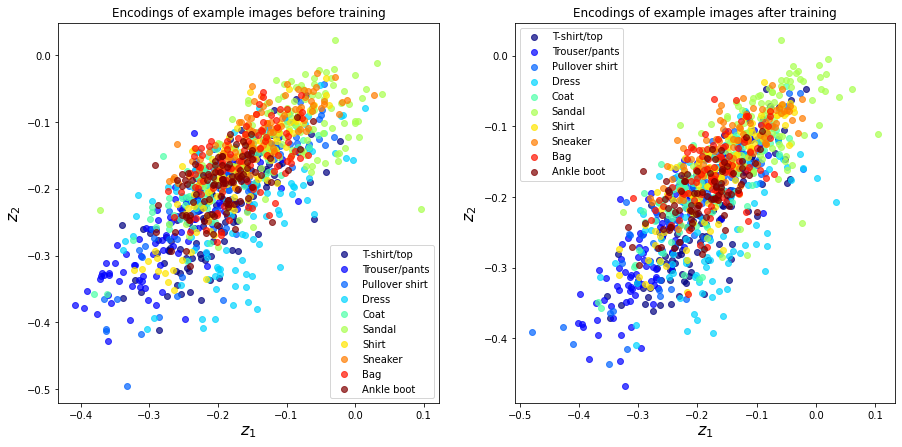

In [43]:
# Plot untrained and trained encodings

plt.figure(figsize=(15, 7))
cmap = cm.get_cmap('jet', 10)

plt.subplot(1, 2, 1)
for i, class_label in enumerate(class_names):
    inx = np.where(untrained_encoding_labels == i)[0]
    plt.scatter(untrained_encodings[inx, 0], untrained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images before training')
plt.legend()

plt.subplot(1, 2, 2)
for i, class_label in enumerate(class_names):
    inx = np.where(trained_encoding_labels == i)[0]
    plt.scatter(trained_encodings[inx, 0], trained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images after training')
plt.legend()

plt.show()

# Training only the encoder with a cross entropy loss

In [20]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train/255.
x_test = x_test/255.

# Add channel axis
print(x_train.shape)
x_train = x_train[..., np.newaxis]
print(x_train.shape)

# Convert labels to one-hot
print(y_test[:3])
y_test = tf.one_hot(indices=y_test, depth=10).numpy()
y_train = tf.one_hot(indices=y_train, depth=10).numpy()
print(y_test[:3])

(60000, 28, 28)
(60000, 28, 28, 1)
[9 2 1]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [21]:
encoded_dim = 2
classes_dim = 10

encoder = Sequential([
    Conv2D(16, 5, activation='relu', input_shape=(28,28,1)),
    MaxPool2D(2),
    Conv2D(8, 5, activation='relu'),
    Flatten(),
    # Dense(64, activation=None),
    Dense(encoded_dim, activation=None)
])

final_layer = Sequential([
    Dense(classes_dim, activation='softmax', input_shape=(encoded_dim,))
])

model = Model(inputs=encoder.input, outputs=final_layer(encoder.output))

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 8)           3208      
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 1026      
                                                           

In [22]:
# Compute encodings before training
inx = np.random.choice(x_test.shape[0], 1000, replace=False)

untrained_encodings = encoder(x_test[inx]).numpy()
untrained_encoding_labels = y_test[inx]

In [23]:
# Create Dataset objects for train and test sets

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Process the datasets

train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
#x_train.shape
train_dataset.element_spec

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))

In [25]:
# Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-3))
model.fit(train_dataset, epochs=20)

Epoch 1/20
938/938 [==============================] - 15s 15ms/step - loss: 0.8860
Epoch 2/20
938/938 [==============================] - 15s 16ms/step - loss: 0.6310
Epoch 3/20
938/938 [==============================] - 14s 15ms/step - loss: 0.5729
Epoch 4/20
938/938 [==============================] - 13s 14ms/step - loss: 0.5326
Epoch 5/20
938/938 [==============================] - 13s 14ms/step - loss: 0.5065
Epoch 6/20
938/938 [==============================] - 13s 14ms/step - loss: 0.4833
Epoch 7/20
938/938 [==============================] - 13s 14ms/step - loss: 0.4698
Epoch 8/20
938/938 [==============================] - 14s 15ms/step - loss: 0.4565
Epoch 9/20
938/938 [==============================] - 14s 15ms/step - loss: 0.4501
Epoch 10/20
938/938 [==============================] - 14s 15ms/step - loss: 0.4403
Epoch 11/20
938/938 [==============================] - 14s 15ms/step - loss: 0.4365
Epoch 12/20
938/938 [==============================] - 14s 15ms/step - loss: 0.4292
E

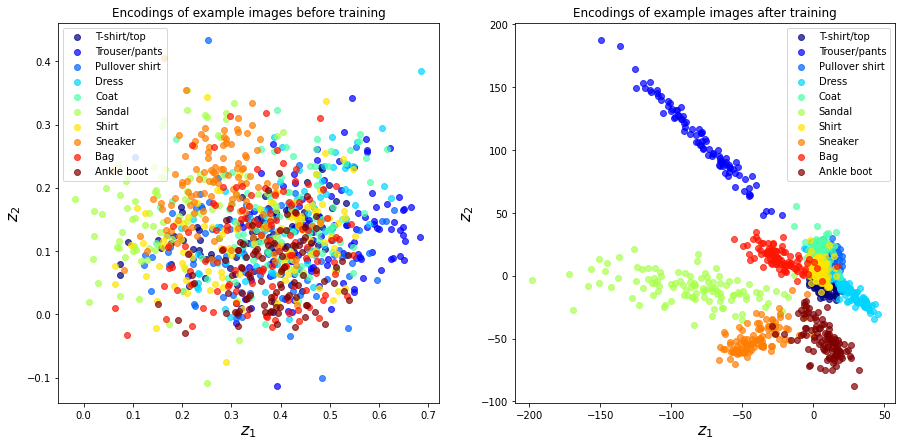

In [26]:
# Compute encodings after training

inx = np.random.choice(x_test.shape[0], 1000, replace=False)
trained_encodings = encoder(x_test[inx]).numpy()
trained_encoding_labels = y_test[inx]

# Un-one-hot labels
trained_encoding_labels_restacked = np.argmax(trained_encoding_labels, axis=1)
untrained_encoding_labels_restacked = np.argmax(untrained_encoding_labels, axis=1)

# Plot untrained and trained encodings

plt.figure(figsize=(15, 7))
cmap = cm.get_cmap('jet', 10)

plt.subplot(1, 2, 1)
for i, class_label in enumerate(class_names):
    inx = np.where(untrained_encoding_labels_restacked == i)[0]
    plt.scatter(untrained_encodings[inx, 0], untrained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images before training')
plt.legend()

plt.subplot(1, 2, 2)
for i, class_label in enumerate(class_names):
    inx = np.where(trained_encoding_labels_restacked == i)[0]
    plt.scatter(trained_encodings[inx, 0], trained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images after training')
plt.legend()

plt.show()